### Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.core.display import display
from sklearn.feature_extraction import stop_words
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error

In [2]:
#importing the raw data

recipes_raw = pd.read_csv("./Data/RAW_recipes.csv")
interactions_raw = pd.read_csv("./Data/RAW_interactions.csv")

In [ ]:
display(recipes_raw.head(5))
print("shape:",recipes_raw.shape)

display(interactions_raw.head(5))
print("shape:",interactions_raw.shape)

In [3]:
#make copies so that we don't have to reload the data

df_r = recipes_raw.copy()
df_i = interactions_raw.copy()

df_r = df_r.rename({"id": "recipe_id"}, axis = 1)
#df_r = df_r.set_index("recipe_id")

## Exploratory data analysis and preprocessing

In [ ]:
#looking at missing data

is_na = pd.DataFrame((df_r.isna().sum()), columns =["sum_na"])
display(is_na[is_na["sum_na"]!=0])

In [4]:
#drop the one na row where the title of the recipe is missing
df_r.drop(df_r[df_r["name"].isna()].index, inplace =True)
df_r.shape

(231636, 12)

In [5]:
# add dummy variable to indicate missing descriptions
df_r["description_na"] = df_r["description"].isna().apply(lambda x: 1 if x == True else 0)

df_r["description"] = df_r["description"].fillna("NA")

print("# rows where description is missing:", len(df_r[df_r["description_na"] == 1]), "|| No mistakes?", len(df_r[df_r["description_na"] == 1]) == len(df_r[df_r["description"] == "NA"]))

# rows where description is missing: 4979 || No mistakes? True


#### Preprocess Minutes column

In [ ]:
display(df_r[df_r["minutes"]==df_r["minutes"].min()])
display(df_r.nlargest(10, 'minutes'))

# let's deal with the 1094 recipes which don't have any minutes later

In [6]:
#minutes -> hours to get a better feeling for the time

df_r["hours"] = df_r["minutes"]/60

In [ ]:
#let's have a look at the really long recipes

df_r[df_r["hours"]>24].name

#we see that there are legit recipes which are very long

In [7]:
#Correct some obvious outliers, but rest of the large recipes are liquors that take months to make

df_r.loc[144074, "minutes"]= 25
df_r.drop(df_r[df_r["name"]=="how to preserve a husband"].index, inplace=True)
df_r.shape

(231635, 14)

In [ ]:
#minutes
plt.figure(figsize=(10,5))
plt.hist(df_r["hours"], log=True)


#### Checking out n_ingredients

In [ ]:
#check number of ingredients
display(df_r.n_ingredients.describe())
df_r["n_ingredients"].plot(kind="box", vert =False, figsize=(16,2))

In [ ]:
df_r[df_r['n_ingredients']<=1]

### Include average ratings into recipe df

In [ ]:
test = pd.DataFrame(df_i.groupby("recipe_id").count())
test[test["review"]==0]

print("# of recipes involved in interactions:", test.shape)

In [ ]:
#check how many reviews where given w/o a rating
print("# interactions w/o rating, only review:",len(df_i[df_i["rating"]==0]))

In [8]:
#create num_interactions & average ratings column

num_interactions = df_i.groupby("recipe_id")["date"].count()
#only consider the ratings (>0) into the mean, not the reviews w/o ratings
mean_ratings = df_i[df_i["rating"]!=0].groupby("recipe_id")["rating"].mean()

df_rmerged = df_r.join(num_interactions, how="left", on="recipe_id").join(mean_ratings, how="left", on="recipe_id")


print("shape after merging:", df_rmerged.shape)

df_rmerged = df_rmerged.rename(columns ={"date":"num_interactions", "rating":"avg_rating"})
df_rmerged.head()

shape after merging: (231635, 16)


,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,0,0.916667,3,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,0,0.500000,4,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,0,2.166667,1,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,0,0.750000,2,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,0,3.166667,1,5.000000


### Create columns for year, month & age

In [9]:
#Preprocess the "submitted" column
df_rmerged["submitted"] = df_rmerged["submitted"].astype(str)

dates = pd.DataFrame(df_rmerged["submitted"].apply(lambda date: date.split("-")).tolist(), index = df_rmerged.index,columns =["year", "month", "day"])

df_rmerged["year"] = dates ["year"]
df_rmerged["month"] = dates["month"]

#create an age column for the recipes
df_rmerged["year"]= df_rmerged["year"].astype(int)
df_rmerged["month"]=df_rmerged["month"].astype(int)
df_rmerged["age"] = (2019-df_rmerged.year)+ df_rmerged.month/12

In [ ]:
#show most popular recipes

display(df_rmerged.describe())

#display(df_rmerged.nlargest(10, 'num_interactions'))

#One can see that the most popular recipes are also very old
df_rmerged["num_interactions"].plot(kind="box", vert =False, figsize=(16,2))

#### Check out n_steps

n_steps has little outliers. Most of 1step recipes just forgot to add paragraphs in their steps description. We can still use text descriptions for NLP -> don't delete

In [ ]:
df_rmerged[df_rmerged['n_steps']==0]

### Eliminating low quality/low interaction/duplicate recipes

In [10]:
#We want some quality in our recommended systems, no description of steps is bad
df_rmerged.drop(df_rmerged[df_rmerged['n_steps']==0].index, inplace=True)

In [11]:
#remove all recipes which are older/younger than 8 years and have less than 15/10 interactions

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=15) & (df_rmerged["age"]>8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing old & inactive recipes:", df_rmerged.shape)

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=10)& (df_rmerged["age"]<=8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing newer & inactive recipes:", df_rmerged.shape)

Shape after removing old & inactive recipes: (21913, 19)
Shape after removing newer & inactive recipes: (11151, 19)


In [12]:
#1 step recipes are not inherently bad, often they are just all steps written into one field, but let's filter by interactions

df_rmerged.drop(df_rmerged[(df_rmerged["n_steps"]==1)&(df_rmerged["num_interactions"]==1)].index, axis=0, inplace =True)
print("Shape after removing 1 step recipes w/ low interactions:", df_rmerged.shape)

Shape after removing 1 step recipes w/ low interactions: (11151, 19)


In [13]:
# same for recipes which don't have any time instructions

df_rmerged.drop(df_rmerged[(df_rmerged['minutes']==0)].index, axis=0, inplace=True)
print('Shape after removing 0 minutes interaction w/ low interactions:', df_rmerged.shape)

Shape after removing 0 minutes interaction w/ low interactions: (11103, 19)


In [14]:
#eliminate duplicate recipes through ratings

#do we have duplicate recipe titles?
print("# duplicate recipe titles:",len(df_rmerged["name"])-len(df_rmerged["name"].unique()))

# duplicate recipe titles: 13


In [15]:
def choose_best(interactions, ratings, n_dupl):
    # number of interaction are different -> there exists a maximum
    if((len(interactions) != len(set(interactions)))) :
        return interactions.idxmax(axis=1)
    else:# return the maximum rating or any of the duplicate recipes
        return ratings.idxmax(axis=1)

In [16]:
dupl_recipes = pd.DataFrame(df_rmerged[df_rmerged["name"].duplicated(keep=False)])
dupl_rgrouped= dupl_recipes.groupby('name').groups

to_keep = []

for name in dupl_rgrouped:
    n_dupl = len(dupl_rgrouped[name])
    if(n_dupl == 2):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        
        interactions = dupl_recipes.loc[[index1, index2], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2], ['avg_rating']].avg_rating
        
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    elif (n_dupl==3):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        index3=dupl_rgrouped[name][2]
        
        interactions = dupl_recipes.loc[[index1, index2, index3], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2, index3], ['avg_rating']].avg_rating
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    else:
        print("Error")
        break 

df_rmerged.drop(df_rmerged.index.intersection(to_keep), axis=0, inplace=True)
print('Shape after dropping duplicates:', df_rmerged.shape)

Shape after dropping duplicates: (11090, 19)


In [17]:
#there are no recipes with an average rating of 0
print("is 0 ratings:", df_rmerged[df_rmerged["avg_rating"]==0])

is 0 ratings: Empty DataFrame
Columns: [name, recipe_id, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients, description_na, hours, num_interactions, avg_rating, year, month, age]
Index: []


In [18]:
#how many recipes don't have any ratings?
print("is na ratings:", df_rmerged["avg_rating"].isna().sum())

df_rmerged.drop(df_rmerged[df_rmerged["avg_rating"].isna()].index, axis=0, inplace =True)
print("Shape after removing recipes w/o ratings:", df_rmerged.shape)

is na ratings: 0
Shape after removing recipes w/o ratings: (11090, 19)


In [ ]:
display(df_rmerged.describe())

### Generate an URL for every recipe

In [ ]:
df_r["URL"] = df_r.apply(lambda row: "https://www.food.com/recipe/"+" ".join(row["name"].split()).replace(" ", "-") 
                         +"-"+str(row["recipe_id"]), axis=1)

In [ ]:
#Check if website exists
# import requests
# from time import sleep

# def website_exists(url):
#     try:
#         request = requests.get(url)
#         if request.status_code == 200:
#             return 1
#         else:
#             return 0
#     except NewConnectionError:
#         return 0
#     except MaxRetryError:
#         print("Max")

### Incuding users into the mix: Creating user-interaction data

In [19]:
df_uactivity = df_i[['recipe_id','user_id', 'rating']]

In [20]:
#Create a user activity dataframe

df_uactivity = df_uactivity.groupby('user_id')['rating'].value_counts().unstack().fillna(0)

cols = list(df_uactivity)
df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]

df_uactivity.head()


rating,0,1,2,3,4,5,total_interactions,total_ratings
user_id,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0
1581,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0


### Filter out inactive users

In [21]:
df_uactivity = df_uactivity[df_uactivity['total_interactions']>=7]
df_uactivity.shape

(17099, 8)

#### Create average rating per user

In [22]:
df_uactivity['uavg_rating'] = df_uactivity.iloc[:,1:6].apply(
    lambda row: np.round(np.ma.average(list(range(1,6)), weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
display(df_uactivity.head())
df_uactivity.shape

C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\ma\extras.py:628: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


rating,0,1,2,3,4,5,total_interactions,total_ratings,uavg_rating
user_id,,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0,4.7
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0,4.5
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0,4.3
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0,4.7
1792,0.0,0.0,0.0,5.0,5.0,21.0,31.0,31.0,4.5


(17099, 9)

In [23]:
df_uactivity = df_uactivity.reset_index()
df_uactivity.columns.set_names(None, inplace = True)

In [24]:
#drop users that only have reviews but no ratings

df_uactivity.drop(df_uactivity[df_uactivity.total_ratings == 0].index, inplace=True, axis=0)
df_uactivity.shape

(17088, 10)

### Create filtered interactions df

In [25]:
# 1. Create Filter for interations with filtered df_uactivity -> Only interactions from active users remain

user_filter = pd.merge(df_uactivity[['user_id']], df_i[['recipe_id','user_id', 'rating']], how = 'left', on ='user_id')

display(user_filter.head())
user_filter.shape

,user_id,recipe_id,rating
0,1533,116345,5
1,1533,32907,5
2,1533,14750,5
3,1533,24136,5
4,1533,63598,4


(839343, 3)

In [26]:
# 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain

interactions = pd.merge(df_rmerged[['recipe_id']], user_filter[['recipe_id', 'user_id', 'rating']], on = 'recipe_id', how ='inner')
display(interactions.head())
interactions.shape

,recipe_id,user_id,rating
0,63986,4470,5
1,63986,28649,4
2,63986,37471,5
3,63986,60992,5
4,63986,75497,5


(328731, 3)

#### Set 0 ratings = average rating of a user so that we don't lose the interaction

In [27]:
print(f'Number of interactions w/ rating: {len(interactions.loc[interactions.rating==0])}')

Number of interactions w/ rating: 8169


In [28]:
def impute_average_rating(row):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating

In [29]:
interactions['rating'] = interactions.apply(impute_average_rating, axis=1)

In [30]:
def get_rating_dist(df_column):
    ratings_series=pd.Series(df_column.value_counts())
    ratings_series.plot.bar()
    print(f'Percent of 5 star rating interactions: {round((ratings_series.loc[5]/len(df_column)*100),2)}%')
    print(f'Percent of 4 star rating interactions: {round((ratings_series.loc[4]/len(df_column)*100),2)}%')
    print(f'Percent of 3 star rating interactions: {round((ratings_series.loc[3]/len(df_column)*100),2)}%')
    print(f'Percent of 2 star rating interactions: {round((ratings_series.loc[2]/len(df_column)*100),2)}%')
    print(f'Percent of 1 star rating interactions: {round((ratings_series.loc[1]/len(df_column)*100),2)}%')

Percent of 5 star rating interactions: 79.63%
Percent of 4 star rating interactions: 15.58%
Percent of 3 star rating interactions: 3.29%
Percent of 2 star rating interactions: 1.03%
Percent of 1 star rating interactions: 0.47%


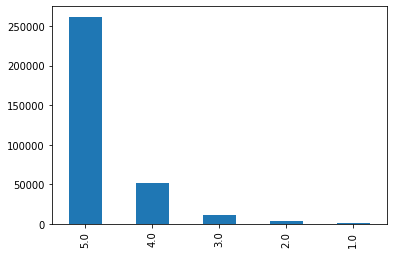

In [31]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

### Creating recipe_id/user_id sparse matrix

In [ ]:
#function to avoid running out of memory (adapted from Chia Chien)

def create_pivot_table(pd_df):
    data = pd_df.values
    #rows = recipes
    rows, row_pos = np.unique(data[:, 0].astype(int), return_inverse=True)
    #columns = users
    cols, col_pos = np.unique(data[:, 1].astype(int), return_inverse=True)
    pivot_matrix = np.zeros((len(rows), len(cols)), dtype=data.dtype)
    pivot_matrix[row_pos, col_pos] = data[:, 2]
    print('Matrix shape:', pivot_matrix.shape)
    df_matrix = pd.DataFrame(pivot_matrix, index = rows, columns = cols)
    return df_matrix

In [ ]:
df_matrix = create_pivot_table(interactions)
df_matrix

## NLP

### Text Preprocessing

In [32]:
## import the libraries
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    #stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [34]:
def get_processed(data):
    processed = pd.DataFrame(data=[],columns = ['recipe_id', 'content'])
    new_texts = []

    for i in range(0, len(data)):
        recipe_id = data['recipe_id'].iloc[i]
        words = nltk.word_tokenize(data['content'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[recipe_id, text]], columns=['recipe_id', 'content'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [35]:
filtered_recipes = pd.unique(interactions['recipe_id'])
df_rfiltered = df_rmerged[df_rmerged.recipe_id.isin(filtered_recipes)]
print(df_rmerged.shape)
df_rfiltered.shape

(11090, 19)


(11050, 19)

In [36]:
def create_content (df, column_names):
    length = len(column_names)
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [37]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_rfiltered = create_content(df_rfiltered[['recipe_id', 'name','description', 'steps']], ['name','description', 'steps'])

df_rfiltered.head()


C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
36,25775,how i got my family to eat spinach spinach cas...
43,58224,immoral sandwich filling loose meat just the t...
53,22526,land of nod cinnamon buns i have made this sev...
67,74805,never weep whipped cream i don't know where i ...


In [38]:
df_rfiltered.shape

(11050, 2)

In [39]:
content_processed = get_processed(df_rfiltered)
content_processed.shape

(11050, 2)

In [43]:
sample = content_processed.sample(n=3000, replace=False, random_state=42)\
                 .reset_index()\
                 .drop(columns=['index'])

### Vectorization

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
def get_cos_sim_matrix(processed):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    #reduce dimensionality of tfidf matrix
    svd = TruncatedSVD(n_components=10, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [63]:
cosine_sim = get_cos_sim_matrix(content_processed)
cosine_sim.shape

(11050, 11050)

### Make prediction function --> for RMSE

In [64]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [45]:
#only relevant if there is a recipe sample

def get_interaction_processed(processed, interactions):
    #fetch only interactions in the preprocessed sample
    interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
    print(f'Interactions before processing: {len(interactions.index)}\nInteractions covered in sample: {len(interactions_processed.index)}')
    return interactions_processed

In [46]:
interactions_processed = get_interaction_processed(sample, interactions)
interactions_processed.head()

Interactions before processing: 328731
Interactions covered in sample: 89697


,recipe_id,user_id,rating
0,63986,4470,5.0
1,63986,28649,4.0
2,63986,37471,5.0
3,63986,60992,5.0
4,63986,75497,5.0


#### a) Make predictions based on tfidf

In [71]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df
for i in range(len(interactions)):
    act, pred = get_one_prediction(cosine_sim, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

In [72]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

RMSE: 0.5236490480539858, MAE: 0.3245386233762958


In [87]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
interactions.head()

,recipe_id,user_id,rating,predicted_rating
0,63986,4470,5.0,4.944262
1,63986,28649,4.0,4.722126
2,63986,37471,5.0,4.926481
3,63986,60992,5.0,4.828718
4,63986,75497,5.0,4.223794


Percent of 5 star rating interactions: 82.54%
Percent of 4 star rating interactions: 16.97%
Percent of 3 star rating interactions: 0.43%
Percent of 2 star rating interactions: 0.05%
Percent of 1 star rating interactions: 0.01%


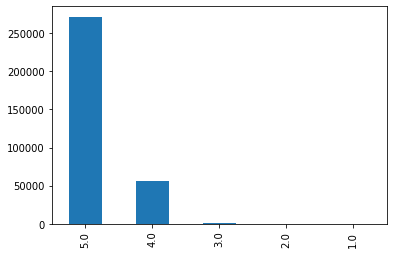

In [91]:
get_rating_dist(round(interactions.predicted_rating))

#### b) Make predictions based on Mixture Model c) based on Word Embeddings etc. ...

In [ ]:
#todo

Recommendation -> =/= already rated -> Coverage
= recommend highest predicted rating NOT seen yet
-> new prediction for ALL recipes for 1 user


<-> Prediction -> RMSE 

### Make recommendations --> Coverage

In [ ]:
#todo

### Word Embedding

In [ ]:
from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

In [ ]:
import gensim.downloader as api

In [ ]:
model = api.load("glove-wiki-gigaword-50")

#### Embed the steps text

In [ ]:
df_rmerged.ingredients =df_r.ingredients
ingredient_list = []
for e in df_rmerged.ingredients.values:
    ingredient_list.extend(eval(e[1:-1]))
    


## Archive

In [ ]:
#add some stopwords
new_stopwords = ['.', '\"', '\'', ':', '(', ')', ',', '-', 'etc', '1', '/', '2', '3', '\'s', '\'\'''','``', '!' ]
stop_words.extend(new_stopwords)


In [ ]:
# plot some distributions
columns =["num_interactions", "avg_rating", "age", "hours", "n_steps", "n_ingredients"]

fig, axes = plt.subplots(6, 1, figsize=(10,30))
i=0
for c in columns:
    axes[i].set_title(c)
    axes[i].hist(df_rmerged[c], log = True)
    i+=1


In [ ]:
# df_rmerged.ingredients = df_r.ingredients
# df_rmerged.ingredients= df_rmerged.ingredients.str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","")


In [ ]:
# count_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "), stop_words ="english", binary=True)
# matrix = count_vectorizer.fit_transform(df_rmerged["ingredients"])

In [ ]:
# m=matrix.toarray()
# m.shape

In [ ]:
# sim_ingredients= next(pairwise_distances_chunked(m, metric="jaccard", n_jobs=-1))

In [ ]:

# i=0
# for chunk in pairwise_distances_chunked(m, metric="jaccard", n_jobs=-1):
#     if i= 0:
#         sim_ingredients= chunk
#         i=1
#         elif:
#             sim_ingredients = np.append(sim_ingredients, chunk, axis=0)

In [ ]:
# sim_ingredients=[]

# x =np.array([[1,2,3,4],[1,2,3,4]])
# sim_ingredients = np.append(x, ([[4,6,7,8],[4,5,6,7]]), axis=0)
# sim_ingredients =np.append(sim_ingredients, ([[4,6,7,8],[4,5,6,7]]), axis=0)
# sim_ingredients